In [44]:
import os
import pandas as pd
import zipfile
import numpy as np
import tensorflow as tf
print(tf.__version__)
import h5py
import random
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sklearn
import tempfile
import gc
import shutil
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical

from keras import models
from keras.models import Model
from keras import layers
from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv3D
from keras.layers import MaxPooling3D
from keras.layers import AveragePooling3D
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers import Lambda
from keras.layers import GlobalAveragePooling3D
from keras_kinetics_i3d.i3d_inception import Inception_Inflated3d

from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K

2.4.0


### Import data from HD5File

In [9]:
PATH_3D_H5 = 'Images/tof_data.hdf5'

In [10]:
with h5py.File(PATH_3D_H5, 'r') as dd:
    print(list(dd.keys()))
    print(dd['X'].shape)
    print(dd['stroke'].shape)

['X', 'pat', 'path', 'stroke']
(508, 128, 112, 40)
(508,)


In [11]:
def decode_data(string):
    decoded_string = [n.decode("UTF-8", "ignore") for n in string]
    return(decoded_string)

with h5py.File(PATH_3D_H5, 'r') as h5:
    print('H5-file: ', list(h5.keys()))
    
    # Image matrices
    X = h5["X"][:]
    # Patient ID's
    pat = h5["pat"][:]
    # Path to images
    path = decode_data(h5["path"][:])
    # Patient labels (1=stroke, 0=TIA)
    Y_pat = h5["stroke"][:]
    
print(len(X), len(Y_pat), len(pat), len(path))

H5-file:  ['X', 'pat', 'path', 'stroke']
508 508 508 508


### Train, validation, test split (vgl. NB Lisa)

There are 508 patients with TOF-MRA images. We split the dataset in a training and test set.
- Training set: 407 images (~80%) -> 281 stroke, 126 non-stroke
- Test set: 101 images (~20%) -> 70 stroke, 31 non-stroke

In [12]:
# consider stroke and no-stroke patients separately:
idx = np.where(Y_pat == 1)[0]
stroke_patients = np.unique(pat[idx])
idx = np.where(Y_pat == 0)[0]
non_stroke_patients = np.unique(pat[idx])
print(len(stroke_patients), len(non_stroke_patients))

351 157


In [13]:
# randomly shuffle the stroke and non-stroke patients
np.random.seed(1)
stroke_patients_test = np.random.choice(stroke_patients, size=len(stroke_patients), replace=False)
non_stroke_patients_test = np.random.choice(non_stroke_patients, size=len(non_stroke_patients), replace=False)

In [14]:
#test set
np.random.seed(1)
test_tmp = np.concatenate([stroke_patients_test[:70], non_stroke_patients_test[:31]], axis=0)
test = np.random.choice(test_tmp, size=len(test_tmp), replace=False)
len(test)

101

In [15]:
stroke_patients_run = [i for i in stroke_patients if i not in test]
non_stroke_patients_run = [i for i in non_stroke_patients if i not in test]

# randomply shuffle the data
np.random.seed(100)
stroke_patients_tmp = np.random.choice(stroke_patients_run, size=len(stroke_patients_run), replace=False)
non_stroke_patients_tmp = np.random.choice(non_stroke_patients_run, size=len(non_stroke_patients_run), replace=False)
print(len(stroke_patients_tmp), len(non_stroke_patients_tmp))

281 126


In [16]:
train_tmp = np.concatenate([stroke_patients_tmp,non_stroke_patients_tmp], axis=0)
len(train_tmp)

407

In [17]:
# randomly shuffle the datasets such that stroke and no-stroke patients are mixed
np.random.seed(100)
train = np.random.choice(train_tmp, size=len(train_tmp), replace=False)
test = np.random.choice(test, size=len(test), replace=False)
print(len(train), len(test))

407 101


In [18]:
def get_datasets(set_i, X, Y_pat, pat, path):
    Y_pat_set = []
    pat_set = []
    path_set = []
    # Find the indices corresponding to the patient_i in set_i
    idx = [i for i, pat_i in enumerate(pat) if pat_i in set_i]
    X_set = X[idx,:,:,:]
    for i in idx:
        Y_pat_set.append(Y_pat[i])
        pat_set.append(pat[i])
        path_set.append(path[i])     
    return(X_set, np.array(Y_pat_set), np.array(pat_set), np.array(path_set))

In [19]:
X_train, Y_train, pat_train, path_train = get_datasets(train, X, Y_pat, pat, path)
X_test, Y_test, pat_test, path_test = get_datasets(test, X, Y_pat, pat, path)

In [20]:
#for softmax
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

### Preprocess data

In [21]:
#IMAGE_DIMENSION = (64, 56, 20)
#IMAGE_DIMENSION = (96, 84, 30)
IMAGE_DIMENSION = (128, 112, 40)
#IMAGE_DIMENSION = (128, 128, 40)

#### Resize images 

In [110]:
def normalize_array(array):
    min = np.min(array)
    max = np.max(array)
    normalized = (array - min) / (max - min)
    return normalized

In [63]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_width = IMAGE_DIMENSION[0]
    desired_height = IMAGE_DIMENSION[1]
    desired_depth = IMAGE_DIMENSION[2]
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    img = normalize_array(img)
    return img

In [64]:
X_train = np.array([resize_volume(img) for img in X_train])
X_test = np.array([resize_volume(img) for img in X_test])

#### Expand dimensions

In [22]:
X_train = np.expand_dims(X_train, axis = 4)
X_train.shape

(407, 128, 112, 40, 1)

In [23]:
X_test = np.expand_dims(X_test, axis = 4)
X_test.shape

(101, 128, 112, 40, 1)

#### Add channels to images -> 1 to 3

In [24]:
X_train = np.repeat(X_train, 3, -1)    
X_train.shape

(407, 128, 112, 40, 3)

In [25]:
X_test = np.repeat(X_test, 3, -1)    
X_test.shape

(101, 128, 112, 40, 3)

### Move depth axis

In [26]:
X_train = np.moveaxis(X_train, 3, 1)
X_train.shape

(407, 40, 128, 112, 3)

In [27]:
X_test = np.moveaxis(X_test, 3, 1)
X_test.shape

(101, 40, 128, 112, 3)

#### Check if values are betwwen 0 and 1

In [28]:
print(np.min(X_train[0]), np.max(X_train[0]))

0.0 1.0


##### Optional: all elements between -0.5 and 0.5

In [337]:
##all elements between -0.5 and 0.5
X_train = X_train - 0.5
X_test = X_test - 0.5

In [338]:
print(np.min(X_train[0]), np.max(X_train[0]))

-0.5 0.5


### Data Augmentation

Zoom images

In [50]:
# zoom
def random_zoom3d(X_im, min_zoom, max_zoom):
    z = np.random.sample() *(max_zoom-min_zoom) + min_zoom
    zoom_matrix = np.array([[z, 0, 0, 0],
                            [0, z, 0, 0],
                            [0, 0, z, 0],
                            [0, 0, 0, 1]])
    return ndimage.affine_transform(X_im, zoom_matrix, mode = "nearest", order = 1)

In [120]:
X_aug = random_zoom3d(X, 0.8, 1.3)
#plot_slices(4, 10, 128, 112, X_aug[:, :, :])
#fig, ax = plt.subplots()
#pos = ax.imshow(np.squeeze(X_aug[:, :, 10]), cmap="gray")

Rotate images

In [51]:
# rotate
def random_rotate3d(X_im, min_angle_xy, max_angle_xy, min_angle_xz, max_angle_xz, min_angle_yz, max_angle_yz):
    angle_xy = np.random.uniform(min_angle_xy, max_angle_xy)
    angle_xz = np.random.uniform(min_angle_xz, max_angle_xz)
    angle_yz = np.random.uniform(min_angle_yz, max_angle_yz)
    rotation_axis = np.random.choice([0,1,2])
    if(rotation_axis == 0):
        X_im = ndimage.rotate(X_im, angle = angle_xy, axes = (0,1), mode = "nearest", reshape = False, order = 3)
    if(rotation_axis == 1):
        X_im = ndimage.rotate(X_im, angle = angle_xz, axes = (0,2), mode = "nearest", reshape = False, order = 3)
    if(rotation_axis == 2):
        X_im = ndimage.rotate(X_im, angle = angle_yz, axes = (1,2), mode = "nearest", reshape = False, order = 3)
    return X_im

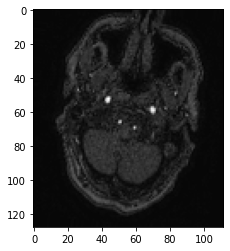

In [36]:
X_aug = random_rotate3d(X, -20, 20, -5, 5, -5, 5)
fig, ax = plt.subplots()
pos = ax.imshow(np.squeeze(X_aug[:, :, 10]), cmap="gray")

Shifting images

In [52]:
# shifting
def random_shift3d(X_im, min_shift_x, max_shift_x, min_shift_y, max_shift_y, min_shift_z, max_shift_z):
    x_shift = np.random.uniform(min_shift_x, max_shift_x)
    y_shift = np.random.uniform(min_shift_y, max_shift_y)
    z_shift = np.random.uniform(min_shift_z, max_shift_z)
    return ndimage.shift(X_im, [x_shift, y_shift, z_shift, 0], mode = "nearest", order = 0)

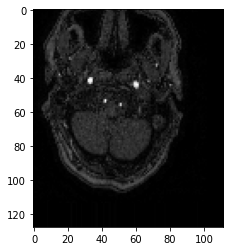

In [39]:
X_aug = random_shift3d(X, -20, 20, -20, 20, 0, 0)
fig, ax = plt.subplots()
pos = ax.imshow(np.squeeze(X_aug[:, :, 10]), cmap="gray")

Flipping images

In [53]:
def random_flip3d(X_im):
    axis = np.random.choice([0,1])
    if(axis == 0): # vertical flip
        X_im = X_im[:,::-1,:,:]
        # X_im = X_im[::-1,:,:,:] #horizontal
        # X_im = np.asarray(X_im).swapaxes(0, 1)#left, right flip
    return X_im

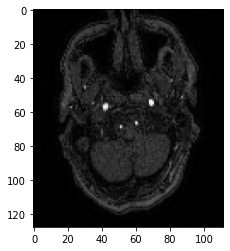

In [45]:
X_aug = random_flip3d(X)
fig, ax = plt.subplots()
pos = ax.imshow(np.squeeze(X_aug[:, :, 10]), cmap="gray")

Gauss filter

In [54]:
# Gauss filter (Glättung, Mittelwertberechnung per Pixel basierend auf umgebenden Pixeln ausgewählt mit Gaussfkt.)
def random_gaussianfilter3d(X_im, sigma_max):
    sigma = np.random.uniform(0, sigma_max)
    return ndimage.gaussian_filter(X_im, sigma, mode = "nearest")

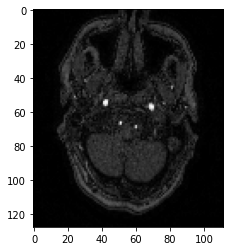

In [52]:
X_aug = random_gaussianfilter3d(X, 0.2)
fig, ax = plt.subplots()
pos = ax.imshow(np.squeeze(X_aug[:, :, 10]), cmap="gray")

In [311]:
@tf.function
def augment_3d(volume):
    """Rotate the volume by a few degrees"""

    def augment(volume):
        #volume = random_zoom3d(volume, 0.8, 1.3)
        volume = random_rotate3d(volume, -20, 20, -5, 5, -5, 5)
        volume = random_shift3d(volume, -20, 20, -20, 20, 0, 0) #do not shift in z direction
        #volume = random_flip3d(volume)
        #volume = random_gaussianfilter3d(volume, 0.2)
        return volume
    
    volume_shape = volume.shape
    augmented_volume = tf.numpy_function(augment, [volume], np.float64)
    augmented_volume = tf.reshape(augmented_volume, volume_shape)
    return augmented_volume

In [325]:
@tf.function
def augment_3d(volume):
    """Rotate the volume by a few degrees"""

    def augment(volume):
        rand = np.random.randint(0,6)
        if rand == 0:
            volume = random_zoom3d(volume, 0.8, 1.3)
        if rand == 1:
            volume = random_rotate3d(volume, -20, 20, -5, 5, -5, 5)
        if rand == 2:
            volume = random_shift3d(volume, -20, 20, -20, 20, 0, 0) #do not shift in z direction
        if rand == 3:
            volume = random_flip3d(volume)
        if rand == 4:
            volume = random_gaussianfilter3d(volume, 0.2)
        if rand == 5:
            volume = volume
        return volume
    
    volume_shape = volume.shape
    augmented_volume = tf.numpy_function(augment, [volume], np.float64)
    augmented_volume = tf.reshape(augmented_volume, volume_shape)
    return augmented_volume

In [312]:
def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    #volume = tf.expand_dims(volume, axis=3)
    volume = augment_3d(volume)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    #volume = tf.expand_dims(volume, axis=3)
    return volume, label

### Define data loaders

In [34]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [35]:
train_loader

<TensorSliceDataset shapes: ((40, 128, 112, 3), (2,)), types: (tf.float64, tf.float32)>

In [36]:
batch_size = 4
# Augment the on the fly during training.
train_dataset = (
    
    train_loader.shuffle(len(X_train))
    #.map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_test))
    #.map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [37]:
train_dataset

<PrefetchDataset shapes: ((None, 40, 128, 112, 3), (None, 2)), types: (tf.float64, tf.float32)>

Dimension of the CT scan is: (40, 128, 112, 3)


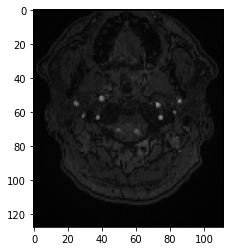

In [123]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[0, :, :]), cmap="gray")

In [19]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    fig = plt.gcf()
    plt.show()
    fig.savefig('Rotatet slices', dpi = 100,bbox_inches='tight')

In [ ]:
# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 112, image[:, :, :40])

### Build CNN

In [77]:
def reset_keras():
    """
    Resets the Tensorflow graph and clears the session. Should be executed after eevery traning session with a model.

    :return:
    """
    sess = tf.compat.v1.keras.backend.get_session()
    tf.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(Session(config=config))

In [92]:
reset_keras()

1509


### Build CNN

In [104]:
conv_base = Inception_Inflated3d(include_top = False,
                             weights = 'rgb_imagenet_and_kinetics',
                             input_shape = X_train[0].shape)
conv_base.summary()

Model: "i3d_inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 40, 128, 112 0                                            
__________________________________________________________________________________________________
Conv3d_1a_7x7_conv (Conv3D)     (None, 20, 64, 56, 6 65856       input_5[0][0]                    
__________________________________________________________________________________________________
Conv3d_1a_7x7_bn (BatchNormaliz (None, 20, 64, 56, 6 192         Conv3d_1a_7x7_conv[0][0]         
__________________________________________________________________________________________________
Conv3d_1a_7x7 (Activation)      (None, 20, 64, 56, 6 0           Conv3d_1a_7x7_bn[0][0]           
______________________________________________________________________________________

In [97]:
def create_model(dropout_rate, img_dim, weights = None, trainable_layer = 'all'):
    '''
    Creates an I3D model with a new classifier for the specified classification task.

    :param dropout_rate: Dropout rate of the last dropout layer of the 3D CNN
    :param trainable_layer: Up to which layer, all layers.trainable are set to false
    :param learning_rate: Learning rate of the model
    :param optimizer: Optimizer of the model (RMSprop, SGD or Adam)
    :return: The complete I3D model
    '''
    
    conv_base = Inception_Inflated3d(include_top = False,
                             weights = weights,
                             input_shape = img_dim)
        
    if trainable_layer == "freeze_base":
        conv_base.trainable = False
        
    elif trainable_layer != "all":
        ##Freeze layers
        for num, layer in enumerate(conv_base.layers):
            layer.trainable = False
            if layer.name == trainable_layer:
                n_layer = num
                break
    
        ###Check if freezing has worked
        for i in range(len(base_model.layers)):
            if i <= n_layer:
                if base_model.layers[i].trainable == True:
                    print("Error in freezing layers (bottom half)")
            if i > n_layer:
                if base_model.layers[i].trainable == False:
                    print("Error in freezing layers (top half)")

    ###Define aditional layers for classification at the end
    global_average_layer = GlobalAveragePooling3D()
    dropout_layer = Dropout(dropout_rate)
    prediction_layer = Dense(units = 2, activation='softmax', kernel_initializer='random_uniform')

    # Setup the models as a Keras sequential model
    model = Sequential([
        conv_base,
        global_average_layer,
        dropout_layer,
        prediction_layer
    ])
    
    return model

### Only train classification layer

In [84]:
pretrained_weights = 'rgb_imagenet_and_kinetics'
model = create_model(dropout_rate = 0.2, 
                     weights = pretrained_weights, 
                     img_dim = X_train[0].shape,
                    trainable_layer = 'freeze_base')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
i3d_inception (Functional)   (None, 4, 1, 1, 1024)     12294544  
_________________________________________________________________
global_average_pooling3d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 12,296,594
Trainable params: 2,050
Non-trainable params: 12,294,544
_________________________________________________________________


#### Compile model

In [85]:
### define metrics
metrics = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc')]

### prepare files for logging
if os.path.exists('results.csv'):
    os.remove('results.csv')
    
shutil.rmtree('History')
os.makedirs('History')
    
filepath = 'History/model.epoch{epoch:02d}.hdf5'
    
### define callback_list
callback_list = [
    keras.callbacks.ModelCheckpoint(filepath=filepath, save_freq='epoch', verbose=1), 
    keras.callbacks.CSVLogger('results.csv')]
    
model.compile(loss = "categorical_crossentropy", 
              optimizer=keras.optimizers.Adam(learning_rate = 0.000001),
              metrics = metrics)

In [86]:
epochs = 60
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    verbose=1,
    callbacks=callback_list)

model.save_weights('Trained_weights/trained_classification_block.h5')

Epoch 1/60
102/102 [==============================] - 24s 141ms/step - loss: 0.9271 - accuracy: 0.3177 - auc: 0.3180 - val_loss: 0.8920 - val_accuracy: 0.3069 - val_auc: 0.2878

Epoch 00001: saving model to History/model.epoch01.hdf5
Epoch 2/60
102/102 [==============================] - 15s 122ms/step - loss: 0.9125 - accuracy: 0.3080 - auc: 0.2991 - val_loss: 0.8728 - val_accuracy: 0.3069 - val_auc: 0.2859

Epoch 00002: saving model to History/model.epoch02.hdf5
Epoch 3/60
102/102 [==============================] - 15s 124ms/step - loss: 0.8651 - accuracy: 0.3275 - auc: 0.3243 - val_loss: 0.8550 - val_accuracy: 0.3069 - val_auc: 0.2876

Epoch 00003: saving model to History/model.epoch03.hdf5
Epoch 4/60
102/102 [==============================] - 16s 122ms/step - loss: 0.8562 - accuracy: 0.3796 - auc: 0.3371 - val_loss: 0.8378 - val_accuracy: 0.3168 - val_auc: 0.2895

Epoch 00004: saving model to History/model.epoch04.hdf5
Epoch 5/60
102/102 [==============================] - 16s 120ms/

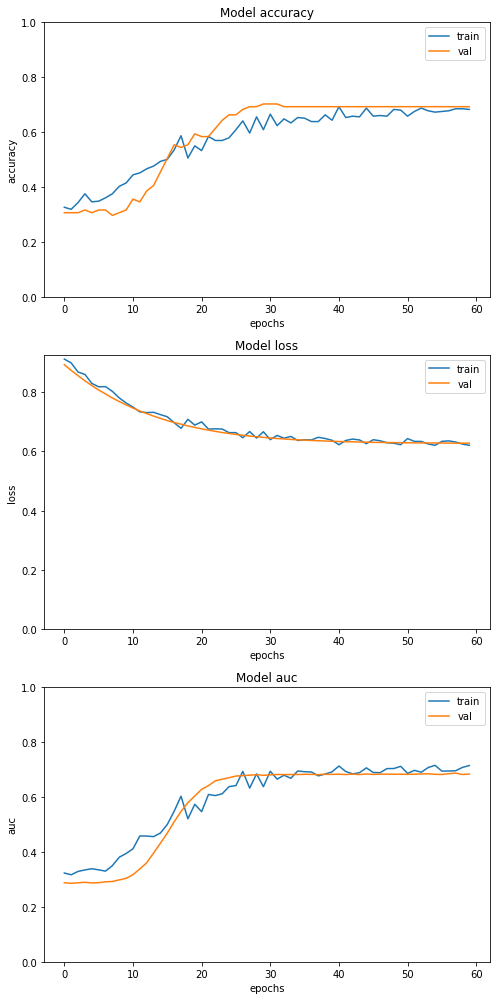

In [101]:
dat = pd.read_csv('results.csv', index_col='epoch')

fig, ax = plt.subplots(3, 1, figsize=(7,14))
metrics = ['accuracy', 'loss', 'auc']

for i, metric in enumerate(metrics):
    ax[i].plot(dat[metric])
    ax[i].plot(dat['val_'+metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
    
    if metric == 'accuracy' or metric == 'auc':
        ax[i].set_ylim(0,1)
        
    else:
        ax[i].set_ylim(0)
    
fig.tight_layout()
plt.show()

p = 'softmax'+str(IMAGE_DIMENSION)
fig.savefig(p)

In [90]:
best_model = np.where(dat.val_loss == np.min(dat.val_loss))[0][0] 
print(best_model)
model.load_weights('History/model.epoch' + str(best_model) + '.hdf5')

y_prob = model.predict(X_test, batch_size=batch_size)
y_pred = (y_prob[:,1] > 0.5).astype(np.int)

y_test = Y_test.argmax(axis = 1) 

59


In [91]:
print("Accuracy: ", np.mean(y_pred == y_test).round(4)*100)
print("AUC: ", sklearn.metrics.roc_auc_score(y_test, y_prob[:,1]).round(3))
print("Confusion matrix: \n", 
      confusion_matrix(y_test, y_pred))

Accuracy:  69.31
AUC:  0.478
Confusion matrix: 
 [[ 0 31]
 [ 0 70]]


### Train all layers

In [100]:
weights = 'Trained_weights/trained_classification_block.h5'
full_model = create_model(dropout_rate = 0.2, 
                     img_dim = X_train[0].shape)
#full_model.load_weights(weights)
full_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
i3d_inception (Functional)   (None, 4, 1, 1, 1024)     12294544  
_________________________________________________________________
global_average_pooling3d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 12,296,594
Trainable params: 12,282,034
Non-trainable params: 14,560
_________________________________________________________________


In [ ]:
### define metrics
metrics = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc')]

### prepare files for logging
if os.path.exists('results.csv'):
    os.remove('results.csv')
    
shutil.rmtree('History')
os.makedirs('History')
    
filepath = 'History/model.epoch{epoch:02d}.hdf5'
    
### define callback_list
callback_list = [
    keras.callbacks.ModelCheckpoint(filepath=filepath, save_freq='epoch', verbose=1), 
    keras.callbacks.CSVLogger('results.csv')]
    
full_model.compile(loss = "categorical_crossentropy", 
              optimizer=keras.optimizers.Adam(learning_rate = 0.000001),
              metrics = metrics)

In [ ]:
epochs = 100
full_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    verbose=1,
    callbacks=callback_list)

model.save_weights('Trained_weights/full_model_weights.h5')